# Power Analysis

Using a 2factor ANOVA, what sample size do we need to achive $\beta=0.8$?

> power is simply the proportion of times that we are able to reject the null hypothesis (remembering that we control the population means and we know that there is a true difference)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_style("whitegrid",{'axes.spines.left' : False,
                           'axes.spines.right': False,
                           'axes.spines.top': False,
                           'grid.linestyle': ':'})
sns.set_context("talk")
participants = pd.read_csv("../data/processed/mock_data/participant-schema.csv",index_col=0)
posts = pd.read_csv("../data/processed/mock_data/posts-schema.csv",index_col=0)
group_cols = ["PROLIFIC_ID","SESSION_ID","treatment","warning","evidence","code"]
reshare_rates = pd.DataFrame(posts.groupby(group_cols)["reshared"].sum() / posts.groupby(group_cols)["reshared"].count()).reset_index()
# Nicely format labels
reshare_rates['treatment'] = reshare_rates['treatment'].replace({False: 'Control',
                                                                 True: 'Treatment'})
reshare_rates['code'] = reshare_rates['code'].str.title()
reshare_rates["evidence"] = reshare_rates["evidence"].str.title()
affirmation_rates = reshare_rates[reshare_rates["code"]=="Affirms"]
affirmation_rates

,PROLIFIC_ID,SESSION_ID,treatment,warning,evidence,code,reshared
0,1,1,Treatment,False,High,Affirms,0.800000
4,1,1,Treatment,False,Low,Affirms,0.000000
7,1,1,Treatment,True,Low,Affirms,0.333333
8,2,2,Treatment,False,High,Affirms,0.333333
12,2,2,Treatment,False,Low,Affirms,0.000000
...,...,...,...,...,...,...,...
2927,497,497,Treatment,True,Low,Affirms,0.000000
2928,498,498,Control,False,High,Affirms,0.800000
2931,498,498,Control,False,Low,Affirms,0.600000
2934,499,499,Control,False,High,Affirms,0.500000


In [14]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from tqdm.notebook import tqdm
from numba import jit

def get_effect(df):
    """
        Gets the effect size, and significance, 
        
        Effect size, eta squared, is derived from this pdf: https://stardock.cs.virginia.edu/empirical/resources/Brown28.pdf
    """
    moore_lm = ols('reshared ~ C(treatment)*C(evidence)',data=df).fit()
    table = sm.stats.anova_lm(moore_lm, typ=2)
    pval = table.iloc[2,3]
    eta_sqr = table.iloc[2,0]/table.iloc[3,0]
    return eta_sqr,pval

sample_sizes = np.linspace(15,300,100,dtype=int)
num_trials = 10
trial_size = 2

def power_simulation(df,sample_sizes,num_trials,trial_size,alpha=0.05):
    res = {"sample_size": [],
           "power": [],
           "avg_eta_sqr": []}
    for ss in tqdm(sample_sizes):
        assert len(df) > ss, f"Sample size ({ss}) larger than dataframe ({len(df)})"
        effect_size = 0
        for _ in range(num_trials):
            num_rejections = 0
            for _ in range(trial_size):
                sampled_df = df.sample(n=ss)
                eta_sqr, pval = get_effect(sampled_df)
                effect_size += eta_sqr
                if pval < alpha: num_rejections +=1
            res["sample_size"].append(ss)
            res["power"].append(num_rejections/trial_size)
            res["avg_eta_sqr"].append(effect_size/trial_size)
    res = pd.DataFrame(res)
    return pd.DataFrame(res)

power_sim = power_simulation(affirmation_rates,sample_sizes,num_trials,trial_size)
power_sim

  0%|          | 0/100 [00:00<?, ?it/s]

,sample_size,power,avg_eta_sqr
0,15,0.0,0.016680
1,15,0.5,0.370828
2,15,0.0,0.433669
3,15,0.5,0.862221
4,15,0.0,1.047820
...,...,...,...
995,300,1.0,0.199452
996,300,0.5,0.216583
997,300,1.0,0.245883
998,300,1.0,0.275781


  0%|          | 0/100 [00:00<?, ?it/s]

/Users/cameron/.local/share/virtualenvs/code-3gDjSy3u/lib/python3.9/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/Users/cameron/.local/share/virtualenvs/code-3gDjSy3u/lib/python3.9/site-packages/statsmodels/base/model.py:1850: RuntimeWarning: invalid value encountered in true_divide
  F /= J
/Users/cameron/.local/share/virtualenvs/code-3gDjSy3u/lib/python3.9/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/Users/cameron/.local/share/virtualenvs/code-3gDjSy3u/lib/python3.9/site-packages/statsmodels/base/model.py:1850: RuntimeWarning: invalid value encountered in true_divide
  F /= J
/Users/cameron/.local/share/virtualenvs/code-3gDjSy3u/lib/pyth

<AxesSubplot:xlabel='sample_size', ylabel='power'>

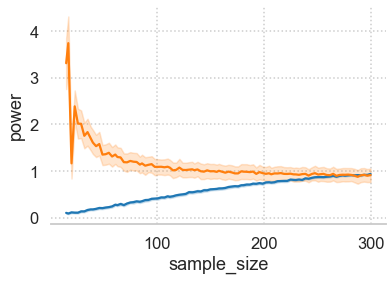

In [16]:
sample_sizes = np.linspace(15,300,100,dtype=int)
num_trials = 50
trial_size = 30

power_sim = power_simulation(affirmation_rates,
                             sample_sizes,
                             num_trials,
                             trial_size)

sns.lineplot(data=power_sim,
             x="sample_size",
             markers=True,
             y="power")

sns.lineplot(data=power_sim,
             x="sample_size",
             y="avg_eta_sqr",
             markers=True)

<AxesSubplot:xlabel='sample_size', ylabel='power'>

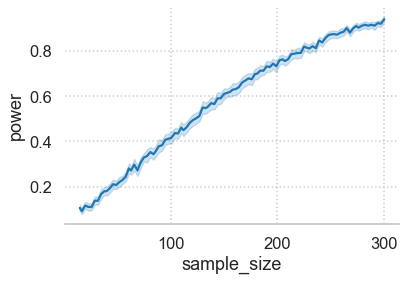

In [17]:
sns.lineplot(data=power_sim,
             x="sample_size",
             markers=True,
             y="power")

In [18]:
power_sim.to_csv("../data/artifacts/power_simulation-alpha=0.05.csv")